# Initialized Gradient Boosted Regression Trees

Выполнил Михаил Притугин BD-31 - вариант 16

# Построение дерева решений

def build(L):

    create node t
    
    if the stopping criterion is True:
    
        assign a predictive model to t
        
    else:
    
        Find the best binary split L = L_left + L_right
        
        t.left = build(L_left)
        
        t.right = build(L_right)
        
    return t 

Для задачи регрессии в качестве меры неопределенности могут выступать

* Среднее квадратичное отклонение от среднего
$$ I(S) = \frac{1}{|S|}\sum\limits_{i \in S}(y_i - \bar{y_S})^2 $$

In [1660]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from time import time

%matplotlib inline

In [1661]:
class TreeRegressor:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None, criterion='mse', max_features=None):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        if criterion == 'mse':
            self.G_function = self._mse
        elif criterion == 'mae':
            self.G_function = self._mae
        else:
            print('invalid criterion name')
            raise

        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features is None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print('invalid max_features name')
            raise
            
    @staticmethod
    def _mse(l_c, r_c):   
        return ((l_c - l_c.mean())**2).sum() + ((r_c - r_c.mean())**2).sum()

    def __get_feature_ids_sqrt(self, n_feature):
        feature_ids = np.arange(n_feature)
        np.random.shuffle(feature_ids)
        return np.array(feature_ids[: max(1, np.int(np.log2(n_feature)))])

    def __get_feature_ids_log2(self, n_feature):
        feature_ids = np.arange(n_feature)
        np.random.shuffle(feature_ids)
        return np.array(feature_ids[: max(1, np.int(np.sqrt(n_feature)))])

    def __get_feature_ids_N(self, n_feature):
        return np.arange(n_feature)
    
    @staticmethod
    def _sort_samples(x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        # Сортируем признаки, а ответы переставляем также,
        # как сортируются признаки
        sorted_x, sorted_y = self._sort_samples(x, y)
        y2_cumsum = np.cumsum(sorted_y ** 2)
        y2_cumsum_reversed = np.cumsum(sorted_y[::-1] ** 2)[::-1]
        y_cumsum = np.cumsum(sorted_y)
        y_cumsum_reversed = np.cumsum(sorted_y[::-1])[::-1]
        y_mean = np.cumsum(sorted_y)
        y_mean_reversed = np.cumsum(sorted_y[::-1])[::-1]
        k = np.array([i for i in range(1, y_mean.size + 1)])
        k_reversed = k[::-1]
        for i in range(y_mean.size):
            y_mean[i] /= (i+1)
        
        n = y_mean_reversed.size
        for i in range(1, y_mean_reversed.size+1):
            y_mean_reversed[n - i] /= i
        
        mse_l = y2_cumsum - 2 * y_cumsum * y_mean +  k * y_mean ** 2
        mse_r = y2_cumsum_reversed - 2 * y_cumsum_reversed * y_mean_reversed + k_reversed * y_mean_reversed ** 2
        
        mse = mse_l
        mse[:-1] += mse_r[1:]

        idx = np.argmin(mse)
        return mse[idx], sorted_x[idx]

    def __fit_node(self, x, y, node_id, depth):
        if (y.size < self.min_samples_split) or (depth == self.max_depth):
            self.tree[node_id] = self.LEAF_TYPE, np.median(y)
            return
        
        # поиск лучшего сплита 
        # feature_ids = self.get_feature_ids(x.shape[1])
        
        buf = np.array([self.__find_threshold(x[:, every], y) for every in range(X.shape[1])])
                
        # номер лучшей фичи, по которой можно сделать сплит
        best_imp = buf[:, :1].argmin()
        
        # threshold = [значение неопределенностьи, порог, номер фичи]
        threshold = list(buf[best_imp]) + [best_imp]
        
        # логика построения дерева
        Xleft, Xright, Yleft, Yright = self.__div_samples(x, y, threshold[2], threshold[1])
        if not Xleft.size or not Xright.size:
            self.tree[node_id] = self.LEAF_TYPE, np.median(y)
        else:
            self.tree[node_id] = self.NON_LEAF_TYPE, threshold[2], threshold[1]
            
            self.__fit_node(Xleft, Yleft, 2 * node_id + 1, depth + 1)
            self.__fit_node(Xright, Yright, 2 * node_id + 2, depth + 1)

    def fit(self, X, y):
        _X = np.copy(X)
        _y = np.copy(y)
        _X = _X.astype('float')
        _y = _y.astype('float')
        self.__fit_node(_X, _y, 0, 0)

    def __predict(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict(x, 2 * node_id + 1)
            else:
                return self.__predict(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        _X = np.copy(X)
        _X = _X.astype('float')
        return np.array([self.__predict(x, 0) for x in _X])

# Тестирование

In [1662]:
myclf = TreeRegressor(max_depth=3)
clf = DecisionTreeRegressor(max_depth=3)

In [1663]:
from sklearn import datasets

In [1664]:
X, y = datasets.load_boston(return_X_y=True)

In [1665]:
myclf.fit(X, y)
clf.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [1666]:
my_pred = myclf.predict(X)
pred = clf.predict(X)

In [1667]:
from sklearn.metrics import mean_absolute_error

In [1668]:
print(f"MAE MyClf = {mean_absolute_error(y, my_pred)}")

MAE MyClf = 2.959090909090909


In [1669]:
print(f"MAE SklearnClf = {mean_absolute_error(y, pred)}")

MAE SklearnClf = 3.0059726993777796


In [1670]:
print(f"MAE MeanClf = {mean_absolute_error(y, np.array([y.mean()]*len(y)))}")

MAE MeanClf = 6.647207423956008


### Постановка ML задачи

##### Решаем задачу восстановления функции в общем контексте обучения с учителем.

##### У нас есть набор пар признаков $ x_i $ и целевых переменных $ y_i $ на котором мы будем восстанавливать зависимость вида $ y = f(x) $. 

##### Восстанавливать будем приближением $ \hat{f}(x) $.

##### Функция потерь $ L(y, f) = (y - f)^2 $, которую мы будем минимизировать:

# $ y \approx \hat{f}(x) $

# $ \hat{f}(x) = \mathop{{\arg\min}\vphantom{\sim}}\limits_{\displaystyle _{\mathbf f(x)}} L(y, f(x)) $

# Представление

### Будем искать приближение $ \hat{f}(x) = \sum_{i=0}^T \hat{f}_i(x) $

# Индукция

##### Предположим, что у нас уже есть $ t-1 $ модель

##### Нужно построить модель под номером $ t $

# $ \hat{f}(x) = \sum_{i=0}^{t-1} \hat{f}_i(x) $

# $ (\rho_t, \theta_t) = \mathop{{\arg\min}\vphantom{\sim}}\limits_{\displaystyle _{\mathbf \rho,\theta}} 𝔼_{x,y}[L(y, \hat{f}_i(x) + \rho*h(x, \theta)] $

# $ \hat{f}_t(x) = \rho_t*h(x, \theta_t) $

# А теперь к практическому поиску параметров

# $ \hat{f}(x) = \sum_{i=0}^{t-1} \hat{f}_i(x) $

# $ r_{it} = -{\left[ \frac{dL(y_i, f(x_i))}{df(x_i)} \right]}_{f(x)=\hat{f}(x)} i=1..n$

# $ \theta_t = \mathop{{\arg\min}\vphantom{\sim}}\limits_{\displaystyle _{\mathbf \theta}} \sum_{i=1}^{n} (r_{it} - h (x_i, \theta))^2 $

# $ \rho_t = \mathop{{\arg\min}\vphantom{\sim}}\limits_{\displaystyle _{\mathbf \rho}} \sum_{i=1}^{n} L(y_i, \hat{f}(x_i) + \rho*h(x_i, \theta_t)) $

# Посмотрим, что мы имеем

### 1) Обучающая выборка $ \{(x_i, y_i)\}_{i=1..n} $

### 2) Число моделей T

### 3) Функция потерь - квадратичная $ L(y, f) = (y - f)^2 $

### 4) Базовый алгоритм - рещающее дерево

### 5) Гиперпараметры базового алгоритма

# Алгоритм

##### 1) Инициализировать GBM RandomForest/ом (?)

##### 2) Для каждой итерации t=1..T:

##### 2.1) Посчитать $ r_{it} = -{\left[ \frac{dL(y_i, f(x_i))}{df(x_i)} \right]}_{f(x)=\hat{f}(x)} i=1..n $

##### 2.2) Построить новый базовый алгоритм  $ h_t(x) $ как регрессию на псевдо-остатках $ \{(x_i, r_{it})\}_{i=1..n} $

##### 2.3) Найти оптимальный коэффициент  $ \rho_t $ при $ h_t(x) $ относительно исходной функции потерь
##### $ \rho_t = \mathop{{\arg\min}\vphantom{\sim}}\limits_{\displaystyle _{\mathbf \rho}} \sum_{i=1}^{n} L(y_i, \hat{f}(x_i) + \rho*h(x_i, \theta)) $

##### 2.4) Сохранить  $ \hat{f}_t(x) = \rho_t*h(x) $

##### 2.5) Обновить текущее приближение $ \hat{f}(x) $ 
##### $ \hat{f}(x) = \sum_{i=0}^{t} \hat{f}_i(x) $ 

##### 3) Получить итоговую модель $ \hat{f}(x) = \sum_{i=0}^{T} \hat{f}_i(x) $

In [1671]:
# Класс модель с константым предсказаем
class ConstModel:
    def __init__(self, value: float):
        self.value = value
        
    def fit(self, X, y):
        pass
    
    def predict(self, X) -> np.array:
        return np.array([self.value]*len(X))

In [1672]:
class GBRT:
    EPS = 0.01
    
    def __init__(self, depth: int=7, n_estimators: int=3, first_model_type: str="RF",
                 rf_n_estimators: int=10, criterion: str='mse',
                n_jobs: int=1, min_samples_split: int=2,
                learning_rate: float=0.3):
        self.depth = depth
        self.n_estimators = n_estimators
        self.first_model_type = first_model_type
        self.rf_n_estimators = rf_n_estimators
        self.criterion = criterion
        self.n_jobs = n_jobs
        self.min_samples_split = min_samples_split
        self.learning_rate = learning_rate
        
    def set_params(self, **params):
        self.depth = params.get("depth")
        self.learning_rate = params.get("learning_rate", 0.1)
        self.n_estimators = params.get("n_estimators")
        self.first_model_type = params.get("first_model_type", "RF")
        self.rf_n_estimators = params.get("rf_n_estimators", 10)
        self.criterion = params.get("criterion", 'mse')
        self.n_jobs = params.get("n_jobs", 1)
        self.min_samples_split = params.get("min_samples_split", 2)
        return self
        
    def get_params(self, deep=True):
        return {
            "depth": self.depth,
            "n_estimators": self.n_estimators,
            "first_model_type": self.first_model_type,
            "rf_n_estimators": self.rf_n_estimators,
            "criterion": self.criterion,
            "n_jobs":self.n_jobs,
            "min_samples_split": self.min_samples_split,
            "learning_rate": self.learning_rate
        }
    
    @staticmethod
    def _L(y_right: np.array, y_pred: np.array) -> float:
        return ((y_right - y_pred)**2).sum()
    
    @staticmethod
    def _dL(y_right: np.array, y_pred: np.array) -> np.array:
        return 2*(y_right - y_pred)
        
    def __searchBestRo(self, y_right: np.array, y_pred: np.array,
                       new_predict: np.array) -> float:
#         ro = -0.5
#         buf = y_right - y_pred
#         loss = [self._L(y_right, y_pred + ro*new_predict)]
#         while True:
#             dLdRo = -2*new_predict @ (buf - ro*new_predict)
#             ro = ro - 0.01*dLdRo
#             loss.append(self._L(y_right, y_pred + ro*new_predict))
#             if (loss[-2] - loss[-1]) < self.EPS:
#                 end = time()
#                 return r
        search_range = np.arange(0.1, 1.0, 0.01)
        
        bufer = np.zeros(len(search_range))
        for i, x in enumerate(search_range):
            bufer[i] = self._L(y_right, y_pred + x*new_predict)
        return search_range[np.argmin(bufer)]
    
    def __searchBestFirstRo(self, y_right: np.array, new_predict: np.array) -> float:
        search_range = np.arange(-1.0, 1.0, 0.01)
        bufer = np.zeros(shape=len(search_range))
        for i, x in enumerate(search_range):
            bufer[i] = self._L(y_right, x*new_predict)
        
        return search_range[np.argmin(bufer)]
            
    
    def fit(self, X, y):
        _X = np.copy(X)
        _y = np.copy(y)
        _X = _X.astype('float')
        _y = _y.astype('float')
        self.models = []
        self.k = []
        # Инициализация первой моделью
        if self.first_model_type == 'CM':
            first_model = ConstModel(0.5)
        elif self.first_model_type == 'RF':
            first_model = RandomForestRegressor(n_estimators=self.rf_n_estimators,
                                                criterion=self.criterion, max_depth=self.depth,
                                               n_jobs=self.n_jobs,
                                               min_samples_split=self.min_samples_split)
        else:
            raise NameError("Bad type of first model")
        first_model.fit(X, y)
        first_predict = first_model.predict(X)
        
        self.models.append(first_model)
        self.k.append(1.0)
        y_pred = first_predict
        for t in range(1, self.n_estimators):
            r = self._dL(y, y_pred)
            
            # Создаем новую модель и учим ее на  псевдо-остатках
            new_model = TreeRegressor(max_depth=self.depth)
            test_model = DecisionTreeRegressor(max_depth=self.depth)
            new_model.fit(X, r)
            test_model.fit(X, r)
            new_predict = new_model.predict(X)
            test_predict = test_model.predict(X)
            
            print(new_predict[:5], r[:5])
            
            # Находим оптимальный коэффициент для новой модели
            ro = sum(r) / (2 * sum(new_predict))
            y_pred += self.learning_rate * ro * new_predict
            # Добавляем модель и ее коэффициент
            self.models.append(new_model)
            self.k.append(ro*self.learning_rate)
    
    def predict(self, X, last=None) -> np.array:
        _X = np.copy(X)
        _X = _X.astype('float')
        answer = np.zeros(shape=len(X))
        if last is None:
            for i, model in enumerate(self.models):
                answer += self.k[i] * model.predict(X)
        else:
            for i, model in enumerate(self.models[:last]):
                answer += self.k[i] * model.predict(X)
        return answer

# Тестирование

In [1673]:
y_right = np.array([0.0]*10)
y_pred = np.array([1.0]*10)
assert GBRT._L(y_right, y_pred) == 10.0

# Создание тестового датасета $ y = sin(x)*cos(x) $

In [1674]:
X = np.arange(-5, 5, 0.03)
y = np.sin(X) * np.cos(X)

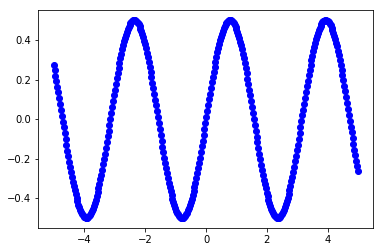

In [1675]:
plt.plot(X, y, 'bo')

##### Добавим шума

In [1676]:
y += np.random.normal(0.0, 0.1, size=len(X))

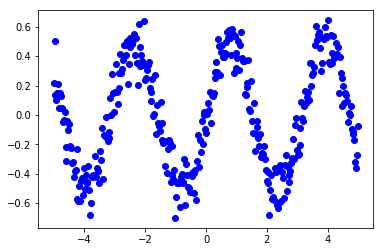

In [1677]:
plt.plot(X, y, 'bo')

# Тестирование модели

In [1678]:
T = 20
depth = 3

In [1679]:
model1 = GBRT(depth, T, first_model_type='CM')
model2 = GBRT(depth, T, first_model_type='RF')

In [1680]:
# Потому что одна фича
X = X.reshape(-1, 1)

In [1681]:
model1.fit(X, y)
model2.fit(X, y)

[-1.26699003 -1.26699003 -1.26699003 -1.26699003 -1.26699003] [-0.5715226   0.00891432 -0.72712935 -0.79849102 -0.6989729 ]
[ 0.09767186  0.09767186 -0.41951501 -0.41951501 -0.41951501] [-0.1925466   0.38789033 -0.34815334 -0.41951501 -0.31999689]
[-0.55570711 -0.55570711 -0.55570711 -0.55570711 -0.55570711] [-0.22123463  0.35920229 -0.22493403 -0.2962957  -0.19677758]
[-0.04902072 -0.04902072 -0.04902072 -0.04902072 -0.04902072] [-0.04902072  0.5314162  -0.05272012 -0.1240818  -0.02456368]
[-0.46938636 -0.46938636 -0.46938636 -0.46938636 -0.46938636] [-0.03429723  0.54613969 -0.03799663 -0.10935831 -0.00984019]
[0.10050369 0.10050369 0.10050369 0.10050369 0.10050369] [0.11339492 0.69383184 0.10969552 0.03833384 0.13785196]
[-0.15885421 -0.15885421 -0.15885421 -0.15885421 -0.15885421] [0.08076753 0.66120445 0.07706813 0.00570645 0.10522457]
[0.05962917 0.05962917 0.05962917 0.05962917 0.05962917] [0.12727846 0.70771538 0.12357906 0.05221738 0.15173551]
[-0.07079369 -0.07079369 -0.07079

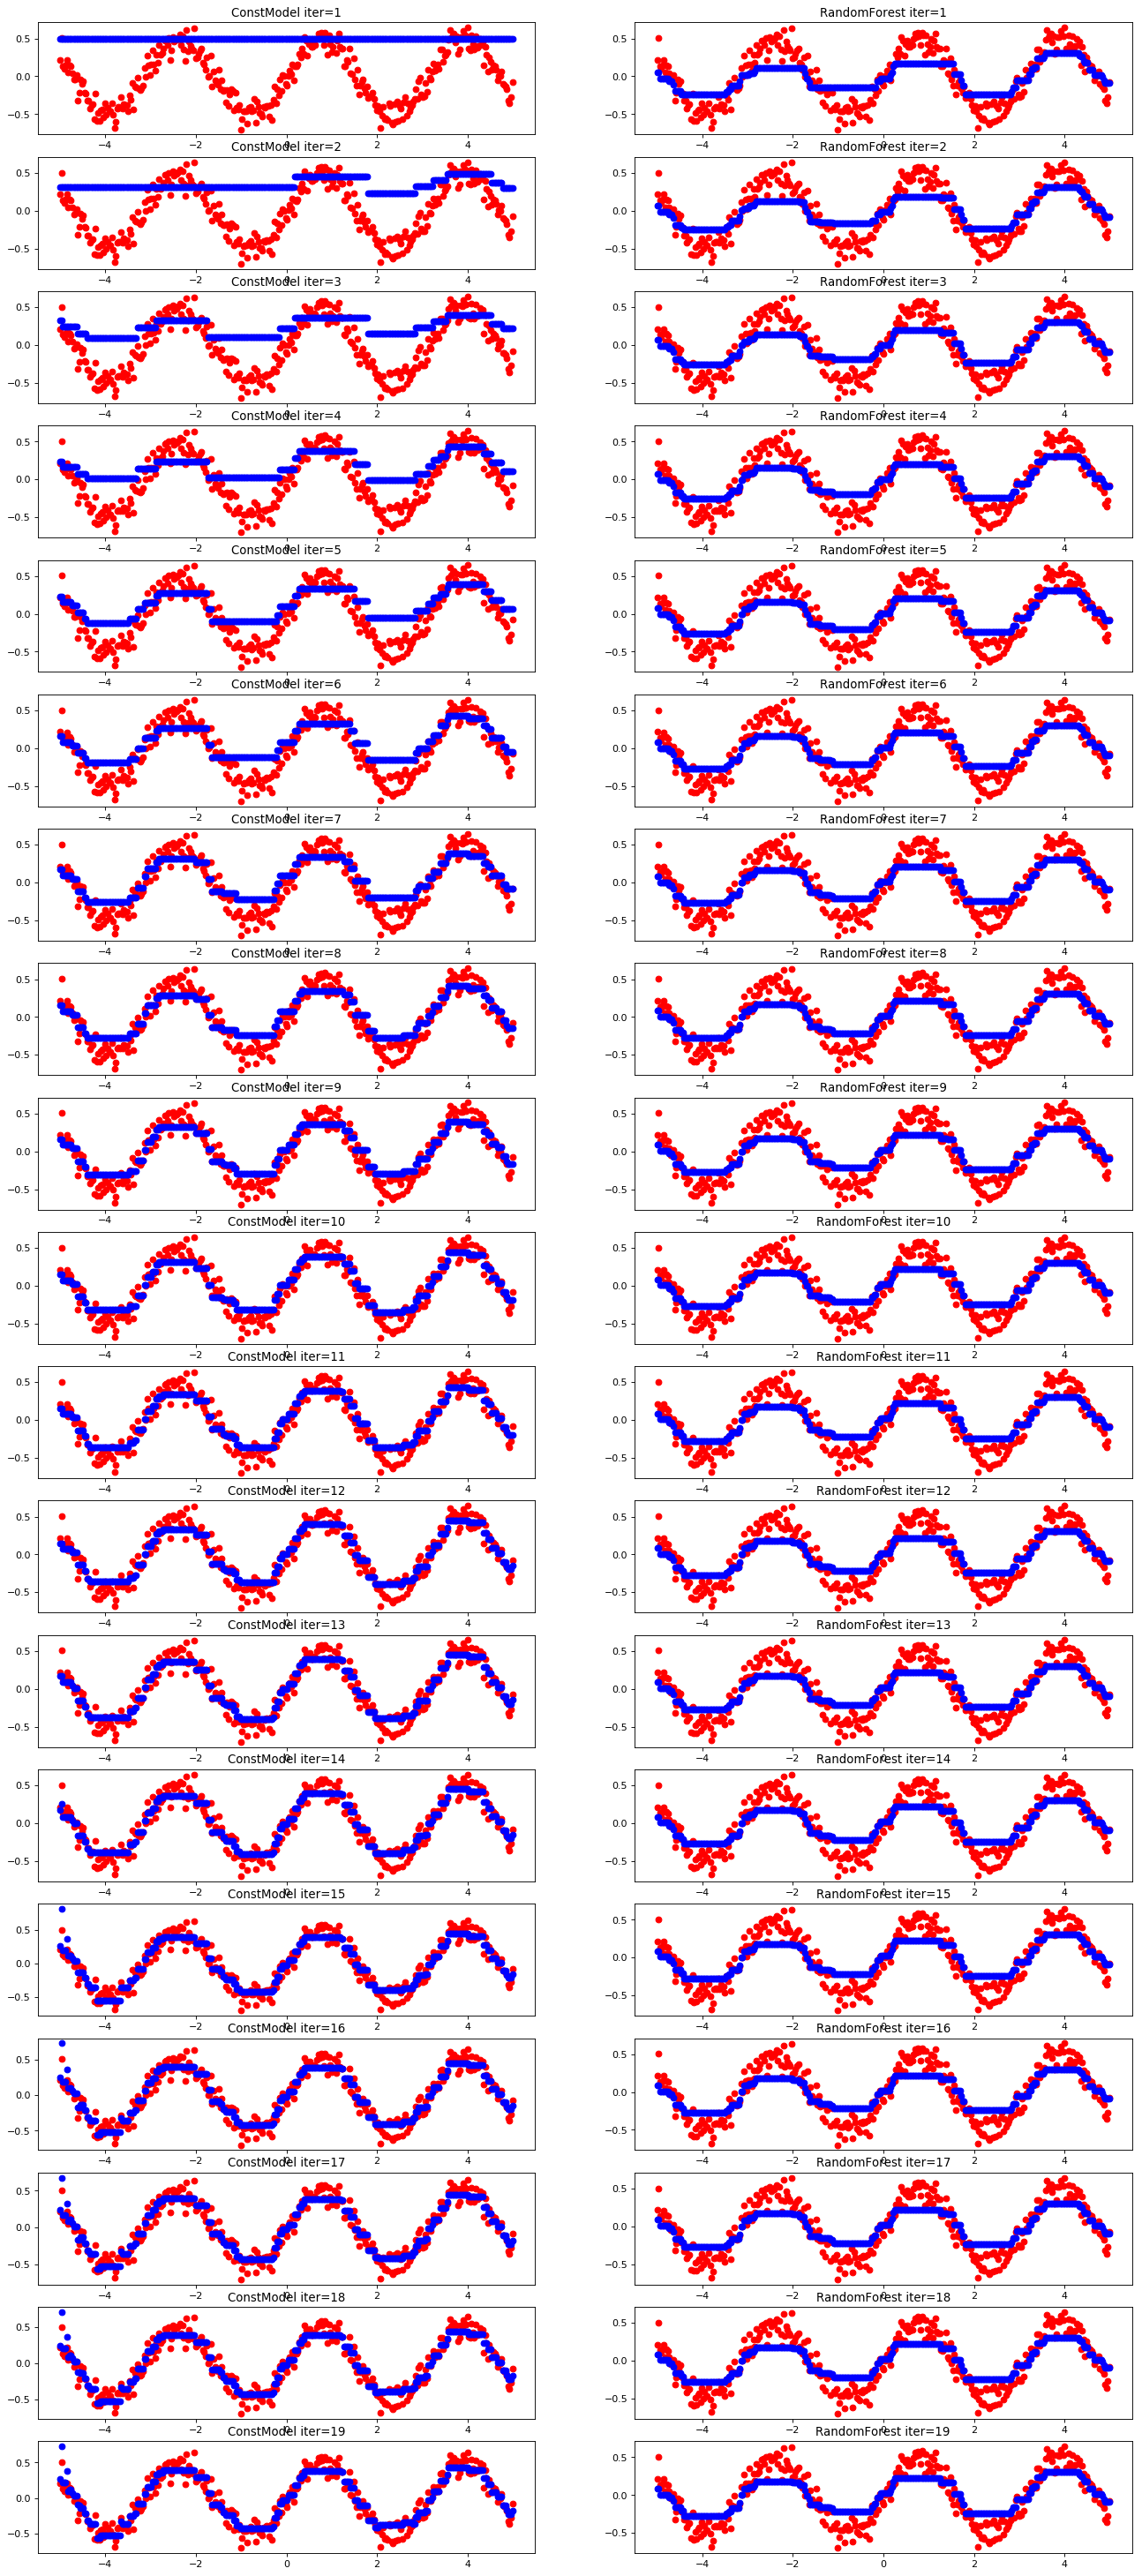

In [1682]:
plt.figure(figsize=(20, 50), dpi=80)
for i in range(1, T):
    plt.subplot2grid((T,2), (i,0))
    y_pred = model1.predict(X, i)
    plt.plot(X, y, 'bo', color='red')
    plt.plot(X, y_pred, 'bo')
    plt.title(f"ConstModel iter={i}")
for i in range(1, T):
    plt.subplot2grid((T,2), (i,1))
    y_pred = model2.predict(X, i)
    plt.plot(X, y, 'bo', color='red')
    plt.plot(X, y_pred, 'bo')
    plt.title(f"RandomForest iter={i}")

# Посмотрим на ошибку в зависимости от итерации

In [1683]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [1684]:
loss1 = []
for i in range(1, T):
    y_pred = model1.predict(X, i)
    loss1.append(mean_absolute_error(y, y_pred))
loss2 = []
for i in range(1, T):
    y_pred = model2.predict(X, i)
    loss2.append(mean_absolute_error(y, y_pred))

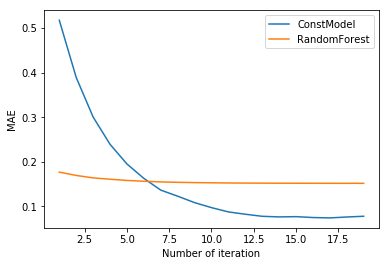

In [1685]:
plt.plot(range(1, T), loss1, label="ConstModel")
plt.plot(range(1, T), loss2, label="RandomForest")
plt.legend()
plt.xlabel("Number of iteration")
plt.ylabel("MAE")
pass

# Выберем модель c RF и построим зависимость от глубины деревьев

[0.15476535 0.15476535 0.15476535 0.15476535 0.15476535] [0.66894466 1.24938158 0.51333792 0.44197624 0.54149436]
[-0.49884912 -0.49884912 -0.49884912 -0.49884912 -0.49884912] [0.63101012 1.21144704 0.47540338 0.4040417  0.50355982]
[-0.58260289 -0.58260289 -0.58260289 -0.58260289 -0.58260289] [0.54725635 1.12769327 0.39164961 0.32028793 0.41980605]
[-0.64123052 -0.64123052 -0.64123052 -0.64123052 -0.64123052] [0.48862871 1.06906563 0.33302197 0.2616603  0.36117842]
[-0.68226987 -0.68226987 -0.68226987 -0.68226987 -0.68226987] [0.44758937 1.02802629 0.29198262 0.22062095 0.32013907]
[-0.71099741 -0.71099741 -0.71099741 -0.71099741 -0.71099741] [0.41886182 0.99929875 0.26325508 0.19189341 0.29141153]
[-0.73110669 -0.73110669 -0.73110669 -0.73110669 -0.73110669] [0.39875254 0.97918947 0.2431458  0.17178413 0.27130225]
[-0.74518319 -0.74518319 -0.74518319 -0.74518319 -0.74518319] [0.38467605 0.96511297 0.22906931 0.15770763 0.25722575]
[-0.75503673 -0.75503673 -0.75503673 -0.75503673 -0.7

[-0.02390429 -0.02390429 -0.02390429 -0.02390429 -0.02390429] [-0.21135225  0.1932676  -0.16951203 -0.04844292  0.0510752 ]
[-0.02404868 -0.02404868 -0.02404868 -0.02404868 -0.02404868] [-0.21149664  0.19312321 -0.16965642 -0.04858732  0.05093081]
[-0.02414975 -0.02414975 -0.02414975 -0.02414975 -0.02414975] [-0.21159772  0.19302214 -0.16975749 -0.04868839  0.05082973]
[-0.0242205 -0.0242205 -0.0242205 -0.0242205 -0.0242205] [-0.21166847  0.19295139 -0.16982824 -0.04875914  0.05075898]
[-0.02427003 -0.02427003 -0.02427003 -0.02427003 -0.02427003] [-0.21171799  0.19290186 -0.16987777 -0.04880867  0.05070946]
[0.22202986 0.62833571 0.18932844 0.23479719 0.41054078] [0.22202986 0.62833571 0.18932844 0.23479719 0.33431531]
[0.46414038 1.31349889 0.39578    0.49082973 0.85821139] [0.46414038 1.31349889 0.39578    0.49082973 0.78198592]
[-0.3142196  -0.88922902 -0.30011411 -0.30011411 -0.50477728] [-0.3142196  -0.88922902 -0.26794013 -0.33228809 -0.65722823]
[-0.292816   -0.82865768 -0.27967

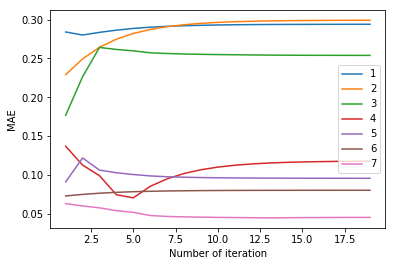

In [1686]:
for d in [1, 2, 3, 4, 5, 6, 7]:
    model = GBRT(d, T, first_model_type='RF')
    model.fit(X, y)
    loss = []
    for i in range(1, T):
        y_pred = model.predict(X, i)
        loss.append(mean_absolute_error(y, y_pred))
    plt.plot(range(1, T), loss, label=f"{d}")
plt.legend()
plt.xlabel("Number of iteration")
plt.ylabel("MAE")
pass

# Теперь тестирование на нормальных данных

In [1687]:
with open("reg.train.txt") as fin:
    data = []
    label = [] 
    for every in fin:
        buf = every.split()
        label.append(float(buf[0]))
        features = np.array([np.nan]*245)
        for p in buf[1:-1]:
            a, b = p.split(':')
            a, b = int(a), float(b)
            features[a] = b
        data.append(features[1:])

In [1688]:
X_train = np.array(data)
y_train = np.array(label)

In [1689]:
with open("reg.test.txt") as fin:
    data = []
    label = [] 
    for every in fin:
        buf = every.split()
        label.append(float(buf[0]))
        features = np.array([np.nan]*245)
        for p in buf[1:-1]:
            a, b = p.split(':')
            a, b = int(a), float(b)
            features[a] = b
        data.append(features[1:])

In [1690]:
X_test = np.array(data)
y_test = np.array(label)

In [1691]:
df_train = pd.DataFrame(X_train)
df_test = pd.DataFrame(X_test)

In [1692]:
X_train = np.array(df_train.fillna(value=0.0))
X_test = np.array(df_test.fillna(value=0.0))

In [1693]:
model = DecisionTreeRegressor(max_depth=3)
myclf = TreeRegressor(max_depth=3)

In [1694]:
%time model.fit(X_train, y_train)

CPU times: user 297 ms, sys: 13.6 ms, total: 311 ms
Wall time: 338 ms


DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [1695]:
%time myclf.fit(X_train, y_train)

CPU times: user 134 ms, sys: 56.3 ms, total: 190 ms
Wall time: 344 ms


In [1696]:
y_pred = model.predict(X_test)
my_pred = myclf.predict(X_test)

In [1697]:
mean_absolute_error(y_test, y_pred)

0.755348669557453

In [1698]:
mean_absolute_error(y_test, my_pred)

0.7818231224875621

# Наша модель

In [1699]:
from sklearn.ensemble import GradientBoostingRegressor

In [1700]:
T = 100

In [1701]:
myclf = GBRT(n_estimators=T, depth=3)
clf = GradientBoostingRegressor(n_estimators=T, max_depth=3)

In [1702]:
%time myclf.fit(X_train, y_train)

[0.16308556 0.16308556 0.22121316 0.16308556 0.16308556] [ 0.08178932 -1.86008309 -0.92723365 -1.38287453 -1.86008309]
[0.16460824 0.16460824 0.22327855 0.16460824 0.16460824] [ 0.08331199 -1.85856042 -0.92516826 -1.38135186 -1.85856042]
[0.16568961 0.16568961 0.22474535 0.16568961 0.16568961] [ 0.08439337 -1.85747904 -0.92370145 -1.38027048 -1.85747904]
[0.16644658 0.16644658 0.22577212 0.16644658 0.16644658] [ 0.08515033 -1.85672208 -0.92267469 -1.37951352 -1.85672208]
[0.16697645 0.16697645 0.22649085 0.16697645 0.16697645] [ 0.08568021 -1.8561922  -0.92195595 -1.37898364 -1.8561922 ]
[0.16734737 0.16734737 0.22699397 0.16734737 0.16734737] [ 0.08605112 -1.85582129 -0.92145284 -1.37861273 -1.85582129]
[0.167607   0.167607   0.22734615 0.167607   0.167607  ] [ 0.08631076 -1.85556165 -0.92110066 -1.37835309 -1.85556165]
[0.16778875 0.16778875 0.22759267 0.16778875 0.16778875] [ 0.0864925  -1.8553799  -0.92085413 -1.37817135 -1.8553799 ]
[0.16791597 0.16791597 0.22776524 0.16791597 0.1

[0.16821283 0.16821283 0.2281679  0.16821283 0.16821283] [ 0.08691658 -1.85495583 -0.9202789  -1.37774727 -1.85495583]
[0.16821283 0.16821283 0.2281679  0.16821283 0.16821283] [ 0.08691658 -1.85495583 -0.9202789  -1.37774727 -1.85495583]
[0.16821283 0.16821283 0.2281679  0.16821283 0.16821283] [ 0.08691658 -1.85495583 -0.9202789  -1.37774727 -1.85495583]
[0.16821283 0.16821283 0.2281679  0.16821283 0.16821283] [ 0.08691658 -1.85495583 -0.9202789  -1.37774727 -1.85495583]
[0.16821283 0.16821283 0.2281679  0.16821283 0.16821283] [ 0.08691658 -1.85495583 -0.9202789  -1.37774727 -1.85495583]
[0.16821283 0.16821283 0.2281679  0.16821283 0.16821283] [ 0.08691658 -1.85495583 -0.9202789  -1.37774727 -1.85495583]
[0.16821283 0.16821283 0.2281679  0.16821283 0.16821283] [ 0.08691658 -1.85495583 -0.9202789  -1.37774727 -1.85495583]
[0.16821283 0.16821283 0.2281679  0.16821283 0.16821283] [ 0.08691658 -1.85495583 -0.9202789  -1.37774727 -1.85495583]
[0.16821283 0.16821283 0.2281679  0.16821283 0.1

In [1703]:
%time clf.fit(X_train, y_train)

CPU times: user 14.2 s, sys: 158 ms, total: 14.4 s
Wall time: 16 s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

# График ошибки на трейне

In [1704]:
loss1 = []
for i in range(1, T):
    y_pred = myclf.predict(X_train, i)
    loss1.append(mean_squared_error(y_train, y_pred))
loss2 = []
for y_pred in clf.staged_predict(X_train):
    loss2.append(mean_squared_error(y_train, y_pred))

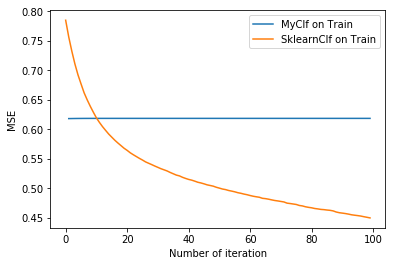

In [1705]:
plt.plot(range(1, T), loss1, label="MyClf on Train")
plt.plot(range(0, T), loss2, label="SklearnClf on Train")
plt.legend()
plt.xlabel("Number of iteration")
plt.ylabel("MSE")
pass

In [1706]:
my_y_pred = myclf.predict(X_test)
y_pred = clf.predict(X_test)

In [1707]:
print(f"MyClf = {mean_squared_error(y_test, my_y_pred)}\nSklearnClf = {mean_squared_error(y_test, y_pred)}")

MyClf = 0.8262428077077237
SklearnClf = 0.7913006218563218


In [1708]:
loss4 = []
for i in range(1, T):
    y_pred = myclf.predict(X_test, i)
    loss4.append(mean_squared_error(y_test, y_pred))
loss3 = []
for y_pred in clf.staged_predict(X_test):
    loss3.append(mean_squared_error(y_test, y_pred))

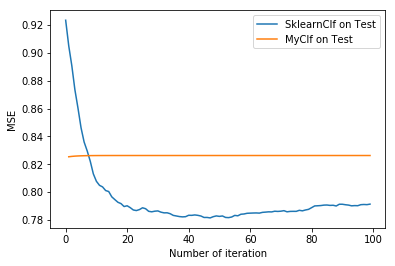

In [1709]:
plt.plot(range(T), loss3, label="SklearnClf on Test")
plt.plot(range(1, T), loss4, label="MyClf on Test")
plt.legend()
plt.xlabel("Number of iteration")
plt.ylabel("MSE")
pass